# **Trans-unet downloading**

In [ ]:
!pip install transunet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.9 MB/s eta 0:00:00


In [ ]:
from transunet import TransUNet
model = TransUNet(image_size=224, pretrain=True)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


461217452/461217452 [==============================] - 18s 0us/step


In [ ]:
import os
!python3 Dual-Cross-Attention/model/double_unet.py

Traceback (most recent call last):
  File "/content/Dual-Cross-Attention/model/double_unet.py", line 4, in <module>
    from model.utils.main_blocks import conv_block, DoubleASPP, params
ModuleNotFoundError: No module named 'model'


# **Cross Model self attention**

In [ ]:
import numpy as np
import tensorflow as tf
import sys

from util import data_reader
from util.processing_tools import *
from util import im_processing, text_processing, eval_tools
from util import loss

class CMSA_model(object):

    def __init__(self,  batch_size = 1,
                        num_steps = 20,
                        vf_h = 40,
                        vf_w = 40,
                        H = 320,
                        W = 320,
                        vf_dim = 2048,
                        vocab_size = 12112,
                        w_emb_dim = 1000,
                        v_emb_dim = 1000,
                        mlp_dim = 500,
                        start_lr = 0.00025,
                        lr_decay_step = 800000,
                        lr_decay_rate = 1.0,
                        rnn_size = 1000,
                        keep_prob_rnn = 1.0,
                        keep_prob_emb = 1.0,
                        keep_prob_mlp = 1.0,
                        num_rnn_layers = 1,
                        optimizer = 'adam',
                        weight_decay = 0.0005,
                        mode = 'eval',
                        weights = 'deeplab',
                        conv5 = False):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.vf_h = vf_h
        self.vf_w = vf_w
        self.H = H
        self.W = W
        self.vf_dim = vf_dim
        self.start_lr = start_lr
        self.lr_decay_step = lr_decay_step
        self.lr_decay_rate = lr_decay_rate
        self.vocab_size = vocab_size
        self.w_emb_dim = w_emb_dim
        self.v_emb_dim = v_emb_dim
        self.mlp_dim = mlp_dim
        self.rnn_size = rnn_size
        self.keep_prob_rnn = keep_prob_rnn
        self.keep_prob_emb = keep_prob_emb
        self.keep_prob_mlp = keep_prob_mlp
        self.num_rnn_layers = num_rnn_layers
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.mode = mode
        self.weights = weights
        self.conv5 = conv5

        self.words = tf.placeholder(tf.int32, [self.batch_size, self.num_steps])
        self.im = tf.placeholder(tf.float32, [self.batch_size, self.H, self.W, 3])
        self.target_fine = tf.placeholder(tf.float32, [self.batch_size, self.H, self.W, 1])


        resmodel = deeplab101.DeepLabResNetModel({'data': self.im}, is_training=False)
        self.visual_feat = resmodel.layers['res5c_relu']

        self.visual_feat_c4 = resmodel.layers['res4b22_relu']
        self.visual_feat_c3 = resmodel.layers['res3b3_relu']

        with tf.variable_scope("text_objseg"):
            self.build_graph()
            if self.mode == 'eval':
                return
            self.train_op()

    def build_graph(self):

        if self.weights == 'deeplab':
            # atrous0 = self._atrous_conv("atrous0", self.visual_feat, 3, self.vf_dim, self.v_emb_dim, 6)
            # atrous1 = self._atrous_conv("atrous1", self.visual_feat, 3, self.vf_dim, self.v_emb_dim, 12)
            # atrous2 = self._atrous_conv("atrous2", self.visual_feat, 3, self.vf_dim, self.v_emb_dim, 18)
            # atrous3 = self._atrous_conv("atrous3", self.visual_feat, 3, self.vf_dim, self.v_emb_dim, 24)
            # visual_feat = tf.add(atrous0, atrous1)
            # visual_feat = tf.add(visual_feat, atrous2)
            # visual_feat = tf.add(visual_feat, atrous3)
            visual_feat_c5 = self._conv("mlp_c5", self.visual_feat, 1, self.vf_dim, self.v_emb_dim, [1, 1, 1, 1])

        embedding_mat = tf.get_variable("embedding", [self.vocab_size, self.w_emb_dim],
                                        initializer=tf.random_uniform_initializer(minval=-0.08, maxval=0.08))
        embedded_seq = tf.nn.embedding_lookup(embedding_mat, tf.transpose(self.words))


        # Generate spatial feature
        spatial = tf.convert_to_tensor(generate_spatial_batch(self.batch_size, self.vf_h, self.vf_w))
        visual_feat_c5 = tf.nn.l2_normalize(visual_feat_c5, 3)

        visual_feat_c4 = tf.nn.l2_normalize(self.visual_feat_c4, 3)
        visual_feat_c3 = tf.nn.l2_normalize(self.visual_feat_c3, 3)


        def f1():
            return tf.constant(0., shape=[1,40,40, 2008]), tf.constant(0., shape=[1,40,40, 1024+1000+8]),tf.constant(0., shape = [1,40,40,512+1000+8])

        def f2():
            w_emb = embedded_seq[n, :, :]

            lang_feat = tf.reshape(w_emb, [self.batch_size, 1, 1, self.rnn_size])
            lang_feat = tf.nn.l2_normalize(lang_feat, 3)
            lang_feat = tf.tile(lang_feat, [1, self.vf_h, self.vf_w, 1])

            feat_all_c5 = tf.concat([visual_feat_c5, lang_feat, spatial], 3) # batch h w c
            feat_all_c4 = tf.concat([visual_feat_c4, lang_feat, spatial], 3) # batch h w c
            feat_all_c3 = tf.concat([visual_feat_c3, lang_feat, spatial], 3) # batch h w c
            return feat_all_c5, feat_all_c4, feat_all_c3


        feat_c5_list=[]
        feat_c4_list=[]
        feat_c3_list=[]
        with tf.variable_scope("RNN"):
            for n in range(self.num_steps): # num_words
                if n > 0:
                    tf.get_variable_scope().reuse_variables()

                feat_c5, feat_c4, feat_c3  = tf.cond(tf.equal(self.words[0, n], tf.constant(0)), f1, f2)
                feat_c5_list.append(feat_c5)
                feat_c4_list.append(feat_c4)
                feat_c3_list.append(feat_c3)


        word_where = tf.transpose(tf.not_equal(self.words, tf.constant(0)))
        self.feat_c5 = tf.boolean_mask(feat_c5_list, word_where)
        self.feat_c5 = tf.expand_dims(self.feat_c5, 0) # batch, n, h, w, c
        self.feat_c4 = tf.boolean_mask(feat_c4_list, word_where)
        self.feat_c4 = tf.expand_dims(self.feat_c4, 0) # batch, n, h, w, c
        self.feat_c3 = tf.boolean_mask(feat_c3_list, word_where)
        self.feat_c3 = tf.expand_dims(self.feat_c3, 0) # batch, n, h, w, c

        #cross-modal self-attention
        self.feat_c5 = self.cmsa_layer(self.feat_c5, 'CMSA', dim = 512, sub =2, out_dim = 2008)

        c5_output = tf.layers.conv2d(self.feat_c5, filters= 500, kernel_size= 1, padding='SAME', dilation_rate=(1, 1),  activation= tf.nn.relu, kernel_initializer= tf.contrib.layers.xavier_initializer())


        self.feat_c4 = tf.layers.conv3d(self.feat_c4, filters= 256, kernel_size= 1, padding='SAME', dilation_rate=(1, 1, 1),  activation= tf.nn.relu, kernel_initializer= tf.contrib.layers.xavier_initializer())
        c4_output = self.cmsa_layer(self.feat_c4, 'CMSA_C4', dim = 128, sub =2, out_dim = 256)
        c4_output = tf.layers.conv2d(c4_output, filters= 500, kernel_size= 1, padding='SAME', dilation_rate=(1, 1),  activation= tf.nn.relu, kernel_initializer= tf.contrib.layers.xavier_initializer())


        self.feat_c3 = tf.layers.conv3d(self.feat_c3, filters= 128, kernel_size= 1, padding='SAME', dilation_rate=(1, 1, 1),  activation= tf.nn.relu, kernel_initializer= tf.contrib.layers.xavier_initializer())
        c3_output = self.cmsa_layer(self.feat_c3, 'CMSA_C3', dim = 64, sub =2, out_dim = 128)
        c3_output = tf.layers.conv2d(c3_output, filters= 500, kernel_size= 1, padding='SAME', dilation_rate=(1, 1),  activation= tf.nn.relu, kernel_initializer= tf.contrib.layers.xavier_initializer())

        #Gated Multi-Level Fusion
        feats_out = self.MGATE('mgate', c5_output,  c4_output, c3_output, c_dim = 500) #
        score = self._conv("score", feats_out, 3, self.mlp_dim, 1, [1, 1, 1, 1])

        self.pred = score
        self.up = tf.image.resize_bilinear(self.pred, [self.H, self.W])
        self.sigm = tf.sigmoid(self.up)


    def MGATE(self, name, h_feats, l1_feats, l2_feats, c_dim, alpha = 0.5 ):
        with tf.variable_scope(name):
            x1 , x2 , x3 = h_feats, l1_feats, l2_feats # batch h w c
            x1_out = self.GATECell('x1', x1, x2,x3, c_dim, alpha)
            x2_out = self.GATECell('x2', x2, x1,x3, c_dim, alpha)
            x3_out = self.GATECell('x3', x3, x1,x2, c_dim, alpha)
            out = x1_out + x2_out + x3_out

            return out

    def GATECell(self, name, x1, x2, x3, c_dim, alpha ):
        with tf.variable_scope(name):
            y = tf.layers.conv2d(x1, filters= c_dim*3, kernel_size= 3, padding='SAME', dilation_rate=(1, 1),  activation= None, kernel_initializer= tf.contrib.layers.xavier_initializer())
            i, f, r = tf.split(y, 3, axis= 3)
            f = tf.sigmoid(f + 1.0)
            r = tf.sigmoid(r + 1.0)
            a = tf.Variable(alpha, trainable=True)
            c = a*f*x2 + (1-a)*f*(x3) + (1-f)*i
            out = r * tf.tanh(c) + (1-r)*x1
            return out

    def cmsa_layer(self, in_feats, name, dim= 512, sub = 2, out_dim = 2008):
        with tf.variable_scope(name):
            theta = tf.layers.conv3d(in_feats, filters= dim, kernel_size= 1, padding='SAME', dilation_rate=(1, 1, 1),  activation= tf.nn.relu, kernel_initializer= tf.contrib.layers.xavier_initializer())
            theta = tf.reshape(theta, [self.batch_size,-1, dim])
            phi = tf.layers.conv3d(in_feats, filters= dim, kernel_size= 1, padding='SAME', dilation_rate=(1, 1, 1),  activation= tf.nn.relu, kernel_initializer= tf.contrib.layers.xavier_initializer())
            phi = tf.layers.max_pooling3d(phi, pool_size = sub, strides=sub, padding='same')
            phi = tf.reshape(phi, [self.batch_size,-1, dim])
            phi = tf.transpose(phi, perm=[0,2,1])
            feat_nl = tf.matmul(theta, phi) # b, thw, thw
            feat_nl = tf.nn.softmax(feat_nl, -1)

            feats = tf.layers.conv3d(in_feats, filters= dim, kernel_size= 1, padding='SAME', dilation_rate=(1, 1, 1),  activation= tf.nn.relu, kernel_initializer= tf.contrib.layers.xavier_initializer()) # bthwc
            feats = tf.layers.max_pooling3d(feats, pool_size = sub, strides=sub, padding='same')
            feats = tf.reshape(feats, [self.batch_size,-1, dim])
            feats = tf.matmul(feat_nl, feats)
            feats = tf.reshape(feats, [self.batch_size,-1, 40,40, dim])

            feats = tf.layers.conv3d(feats, filters= out_dim, kernel_size= 1, padding='SAME', dilation_rate=(1, 1, 1),  activation= tf.nn.relu, kernel_initializer= tf.contrib.layers.xavier_initializer())
            feats = feats + in_feats

            feats = tf.reduce_mean(feats, axis=1, keep_dims=False)
            return feats

    def _conv(self, name, x, filter_size, in_filters, out_filters, strides):
        with tf.variable_scope(name):
            w = tf.get_variable('DW', [filter_size, filter_size, in_filters, out_filters],
                initializer=tf.contrib.layers.xavier_initializer_conv2d())
            b = tf.get_variable('biases', out_filters, initializer=tf.constant_initializer(0.))
            return tf.nn.conv2d(x, w, strides, padding='SAME') + b


    def train_op(self):
        if self.conv5:
            tvars = [var for var in tf.trainable_variables() if var.op.name.startswith('text_objseg')
                        or var.name.startswith('res5') or var.name.startswith('res4')
                        or var.name.startswith('res3')]
        else:
            tvars = [var for var in tf.trainable_variables() if var.op.name.startswith('text_objseg')]
        reg_var_list = [var for var in tvars if var.op.name.find(r'DW') > 0 or var.name[-9:-2] == 'weights']
        print('Collecting variables for regularization:')
        for var in reg_var_list: print('\t%s' % var.name)
        print('Done.')

        # define loss
        self.target = tf.image.resize_bilinear(self.target_fine, [self.vf_h, self.vf_w])
        self.cls_loss = loss.weighed_logistic_loss(self.up, self.target_fine, 1, 1)
        self.reg_loss = loss.l2_regularization_loss(reg_var_list, self.weight_decay)
        self.cost = self.cls_loss + self.reg_loss

        # learning rate
        lr = tf.Variable(0.0, trainable=False)
        self.learning_rate = tf.train.polynomial_decay(self.start_lr, lr, self.lr_decay_step, end_learning_rate=0.00001, power=0.9)

        # optimizer
        if self.optimizer == 'adam':
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
        else:
            raise ValueError("Unknown optimizer type %s!" % self.optimizer)

        # learning rate multiplier
        grads_and_vars = optimizer.compute_gradients(self.cost, var_list=tvars)
        # var_lr_mult = {var: (2.0 if var.op.name.find(r'biases') > 0 else 1.0) for var in tvars}
        var_lr_mult = {}
        for var in tvars:
            if var.op.name.find(r'biases') > 0:
                var_lr_mult[var] = 2.0
            elif var.name.startswith('res5') or var.name.startswith('res4') or var.name.startswith('res3'):
                var_lr_mult[var] = 1.0
            else:
                var_lr_mult[var] = 1.0
        print('Variable learning rate multiplication:')
        for var in tvars:
            print('\t%s: %f' % (var.name, var_lr_mult[var]))
        print('Done.')
        grads_and_vars = [((g if var_lr_mult[v] == 1 else tf.multiply(var_lr_mult[v], g)), v) for g, v in grads_and_vars]
        # grads_and_vars = [((g if not v.name.startswith('res5') else tf.clip_by_norm(g, 0.1)), v) for g, v in grads_and_vars]

        # training step
        self.train_step = optimizer.apply_gradients(grads_and_vars, global_step=lr)

ModuleNotFoundError: No module named 'deeplab_resnet'

# **Staircase model code**

In [ ]:
###########################################                        staircasenet model code                                      ######################################################=



from tensorflow.keras.layers import Conv2D,concatenate,Conv2DTranspose,Input,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model

def staircase_net(input_shape):
    inputs = Input(shape = input_shape)

    #convolution block1
    conv1 = Conv2D(64,3,activation = 'relu',padding = 'same')(inputs)
    x = BatchNormalization()(conv1)
    conv2 = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv2)
    conv3 = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
    op1 = BatchNormalization()(conv3)

    #upsampling layer 1
    up1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same")(op1)

    #convolution block 2
    conv4 = Conv2D(32,3,activation = 'relu',padding = 'same')(up1)
    x = BatchNormalization()(conv4)
    conv5 = Conv2D(32,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv5)
    conv6 = Conv2D(32,3,activation = 'relu',padding = 'same')(x)
    op2 = BatchNormalization()(conv5)

    #downsampling layer
    pool1 = MaxPooling2D(pool_size = (2,2),strides=(2,2))(op2)
    concat1 = concatenate([op1,pool1])

    #convolution block 3
    conv7 = Conv2D(64,3,activation = 'relu',padding = 'same')(concat1)
    x = BatchNormalization()(conv7)
    conv8 = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv8)
    conv9 = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv9)
    conv10 = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
    op3 = BatchNormalization()(conv10)

    #downsampling
    pool2 = MaxPooling2D(pool_size = (2,2),strides=(2,2))(op3)

    #convolution block 4
    conv11 = Conv2D(128,3,activation = 'relu',padding = 'same')(pool2)
    x = BatchNormalization()(conv11)
    conv12 = Conv2D(128,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv12)
    conv13 = Conv2D(128,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv13)

    #upsampling
    up2 = Conv2DTranspose(128,3,strides=(2,2),activation = 'relu',padding = 'same')(x)
    concat2 = concatenate([op3,up2])

    #convolution block5
    conv14 = Conv2D(16,3,activation = 'relu',padding = 'same')(concat2)
    x = BatchNormalization()(conv14)
    conv15 = Conv2D(16,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv15)
    conv16 = Conv2D(16,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv16)

    conv17 = Conv2D(1,1,activation = 'sigmoid',padding = 'same')(x)
    op4 = BatchNormalization()(conv17)

    concat3 = concatenate([inputs,conv17])

    #convolution block 6
    conv18  = Conv2D(64,3,activation = 'relu',padding = 'same')(concat3)
    x = BatchNormalization()(conv18)
    conv19 = Conv2D(64,3,activation = 'relu' ,padding = 'same')(conv18)
    x = BatchNormalization()(conv19)
    conv20 = Conv2D(64,3,activation = 'relu',padding='same')(conv19)
    op5 = BatchNormalization()(conv20)

    up3 = Conv2DTranspose(64,3,strides=(2,2),activation = 'relu',padding = 'same')(x)
    conv21 = Conv2D(32,3,activation = 'relu',padding = 'same')(up3)
    x = BatchNormalization()(conv21)
    conv22 = Conv2D(32,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv22)
    conv23 = Conv2D(32,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv23)
    pool3 = MaxPooling2D(pool_size = (2,2),strides=(2,2))(x)

    concat4 = concatenate([op5,pool3])

    conv24 = Conv2D(64,3,activation = 'relu',padding = 'same')(concat4)
    x = BatchNormalization()(conv24)
    conv25 = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv25)
    conv26 = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv26)
    conv27 = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
    op6 = BatchNormalization()(conv27)

    pool4 = MaxPooling2D(pool_size = (2,2),strides=(2,2))(op6)

    conv28 = Conv2D(128,3,activation = 'relu',padding = 'same')(pool4)
    x = BatchNormalization()(conv28)
    conv29 = Conv2D(128,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv29)
    conv30 = Conv2D(128,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv30)

    up4 = Conv2DTranspose(128,3,strides=(2,2),activation = 'relu',padding = 'same')(x)
    concat5 = concatenate([op6,up4])

    conv31 = Conv2D(16,3,activation = 'relu',padding = 'same')(concat5)
    x = BatchNormalization()(conv31)
    conv32 = Conv2D(16,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv32)
    conv33 = Conv2D(16,3,activation = 'relu',padding = 'same')(x)
    x = BatchNormalization()(conv33)

    conv34 = Conv2D(1,1,activation = 'sigmoid',padding = 'same')(x)


    model = Model(inputs, conv34, name="staircasenet")

    return model


input_shape = (512, 512, 3)
model = staircase_net(input_shape)
model.summary()

Model: "staircasenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 512, 512, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 512, 512, 64)         256       ['conv2d_24[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_25 (Conv2D)          (None, 512, 512, 64)         36928     ['batch_normalizati

# **Includes both u-net and attention-unet Model code**

In [ ]:
#https://youtu.be/csFGTLT6_WQ
# u-net model

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
'''def simple_unet_model(input_shape):
#Build the model
    inputs = Input(input_shape)
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs],name="U-NET")

    return model

if __name__ == "__main__":
    input_shape = (256, 256, 1)
    model = simple_unet_model(input_shape)
    model.summary()'''

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

def conv_block(x, num_filters, dropout_rate=0.2):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Dropout(dropout_rate)(x)  # Added Dropout layer

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Dropout(dropout_rate)(x)  # Added Dropout layer

    return x

def encoder_block(x, num_filters, dropout_rate=0.2):
    x = conv_block(x, num_filters, dropout_rate)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters, dropout_rate=0.2):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters, dropout_rate)
    return x

def attention_unet(input_shape, dropout_rate=0.2):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64, dropout_rate)
    s2, p2 = encoder_block(p1, 128, dropout_rate)
    s3, p3 = encoder_block(p2, 256, dropout_rate)

    b1 = conv_block(p3, 512, dropout_rate)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256, dropout_rate)
    d2 = decoder_block(d1, s2, 128, dropout_rate)
    d3 = decoder_block(d2, s1, 64, dropout_rate)

    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 1)
    model = attention_unet(input_shape)
    model.summary()


AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

# **Modified att unet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

def conv_block(x, num_filters, dropout_rate=0.2):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("swish")(x)
    x = L.Dropout(dropout_rate)(x)  # Added Dropout layer

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("swish")(x)
    x = L.Dropout(dropout_rate)(x)  # Added Dropout layer

    return x

def encoder_block(x, num_filters, dropout_rate=0.2):
    x = conv_block(x, num_filters, dropout_rate)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("swish")(Wg * Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters, dropout_rate=0.2):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters, dropout_rate)
    return x

def attention_unet(input_shape, dropout_rate=0.2):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64, dropout_rate)
    s2, p2 = encoder_block(p1, 128, dropout_rate)
    s3, p3 = encoder_block(p2, 256, dropout_rate)

    b1 = conv_block(p3, 512, dropout_rate)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256, dropout_rate)
    d2 = decoder_block(d1, s2, 128, dropout_rate)
    d3 = decoder_block(d2, s1, 64, dropout_rate)

    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 1)
    model = attention_unet(input_shape)
    model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 256, 256, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 256, 256, 64)         256       ['conv2d_24[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_20 (Activation)  (None, 256, 256, 64)         0         ['batch_normaliza

# **Import needed libraries**

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion, CoarseDropout


In [ ]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **[Optional: resizing part and augmentation code]**

In [ ]:
import os
original_folder ='/content/drive/MyDrive/augment_train/images'
# resized_folder='C:/Users/Admin-1/Downloads/DRIVE-20230825T055623Z-001/DRIVE/image resized'
filename1 = os.listdir(original_folder)
print(len(filename1))

FileNotFoundError: ignored

In [ ]:
#resizing images and saving it into resized folder

original_folder ='/content/drive/MyDrive/augment_train/images'
resized_folder='C:/Users/Admin-1/Downloads/DRIVE-20230825T055623Z-001/DRIVE/image resized'
filename1 = os.listdir(original_folder)
filename1.sort()
for i in tqdm(filename1):

  img_path = original_folder+'/'+i
  img = Image.open(img_path)
  img=img.resize((224,224))
  newimgpath=resized_folder+'/'+i
  img.save(newimgpath)

original_folder ='/content/drive/MyDrive/augment_test/images'
resized_folder='C:/Users/Admin-1/Downloads/DRIVE-20230825T055623Z-001/DRIVE/image resized'
filename1 = os.listdir(original_folder)
filename1.sort()

for i in tqdm(filename1):

  img_path = original_folder+'/'+i
  img = Image.open(img_path)
  img=img.resize((224,224))
  newimgpath=resized_folder+'/'+i
  img.save(newimgpath)

original_folder ='C:/Users/Admin-1/Downloads/DRIVE-20230825T055623Z-001/DRIVE/training_mask'
resized_folder='C:/Users/Admin-1/Downloads/DRIVE-20230825T055623Z-001/DRIVE/mask resized'
filename1 = os.listdir(original_folder)
filename1.sort()

filename1.pop(0)
for i in tqdm(filename1):

  img_path = original_folder+'/'+i
  img = Image.open(img_path)
  img=img.resize((224,224))
  newimgpath=resized_folder+'/'+i
  img.save(newimgpath)

original_folder ='C:/Users/Admin-1/Downloads/DRIVE-20230825T055623Z-001/DRIVE/test_mask'
resized_folder='C:/Users/Admin-1/Downloads/DRIVE-20230825T055623Z-001/DRIVE/mask resized'
filename1 = os.listdir(original_folder)
filename1.sort()
filename1.pop(0)
for i in tqdm(filename1):

  img_path = original_folder+'/'+i
  img = Image.open(img_path)
  img=img.resize((224,224))
  newimgpath=resized_folder+'/'+i
  img.save(newimgpath)

100%|██████████| 20/20 [00:00<00:00, 108.27it/s]


['01_test.jpg', '02_test.jpg', '03_test.jpg', '04_test.jpg', '05_test.jpg', '06_test.jpg', '07_test.jpg', '08_test.jpg', '09_test.jpg', '10_test.jpg', '11_test.jpg', '12_test.jpg', '13_test.jpg', '14_test.jpg', '15_test.jpg', '16_test.jpg', '17_test.jpg', '18_test.jpg', '19_test.jpg', '20_test.jpg']


100%|██████████| 20/20 [00:00<00:00, 225.87it/s]


In [ ]:

# train_x = sorted(glob("C:\\Users\\abhin\\OneDrive\\Documents\\preprocessed_train\\*.jpg"))

train_x = sorted(glob(os.path.join("/content/drive/MyDrive/preprocessed_train/", "*.jpg")))

train_y = sorted(glob("/content/drive/MyDrive/Drive_final/mask_train/*.gif"))

test_x = sorted(glob("/content/drive/MyDrive/preprocessed_test/*.jpg"))
test_y = sorted(glob("/content/drive/MyDrive/Drive_final/mask_test/*.gif"))
test_x


['/content/drive/MyDrive/preprocessed_test/preprocessed01_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed02_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed03_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed04_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed05_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed06_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed07_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed08_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed09_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed10_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed11_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed12_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed13_test.jpg',
 '/content/drive/MyDrive/preprocessed_test/preprocessed14_test.jpg',
 '/content/drive/MyDrive/preproces

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def augment_data(images, masks, save_path, augment=True):
    H = 224
    W = 224

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting names """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']


            X = [x, x1, x2, x4]
            Y = [y, y1, y2, y4]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(X) == 1:
                tmp_image_name = f"{name}.jpg"
                tmp_mask_name = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{index}.jpg"
                tmp_mask_name = f"{name}_{index}.jpg"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            # create_dir(image_path)
            # create_dir(mask_path)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

In [ ]:
# cv2.imshow("",cv2.imread("C:\\Users\\abhin\\OneDrive\\Documents\\preprocessed_test\\preprocessed01_test.jpg", cv2.IMREAD_COLOR))
x=cv2.imread(r"C:\Users\mutha\Downloads\preprocessed_test\preprocessed10_test.jpg")
cv2.imwrite("new_data\\train\\image\\21_training (1)_0.jpg",x)

False

In [ ]:
augment_data(train_x, train_y, "/content/Augmented/train/", augment=True)
augment_data(test_x, test_y, "/content/Augmented/test/", augment=True)

100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


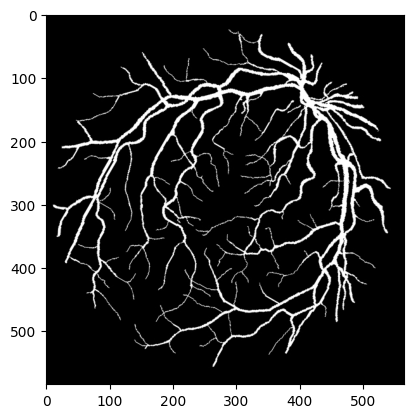

In [ ]:
img=cv2.imread("/content/drive/MyDrive/DRIVE/augmented/masks/Copy of 01_manual107.png")
img=Image.fromarray(img)
# img = img.resize((256,256))

plt.imshow(img,cmap='gray')

# **Feature Extraction**

In [ ]:
image_directory_training = '/content/drive/MyDrive/files/patches_raw_25/images/'
mask_directory_training = '/content/drive/MyDrive/files/patches_raw_25/masks/'
#image_directory_test = '/content/drive/MyDrive/test_aug/images/'
#mask_directory_test = '/content/drive/MyDrive/test_aug/masks/'

SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = os.listdir(image_directory_training)
images.sort()
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory_training+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

'''images = os.listdir(image_directory_test)
images.sort()

for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):

        image = cv2.imread(image_directory_test+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))
'''
#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory_training)
masks.sort()
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory_training+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

'''masks = os.listdir(mask_directory_test)
masks.sort()
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory_test+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))'''


#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
# image_dataset = np.asarray(image_dataset).astype('float32').reshape((-1,3))
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
# mask_dataset = np.asarray(mask_dataset).astype('float32').reshape((-1,3))

In [ ]:
print(len(image_dataset))
mask_dataset[0].shape

1000


(256, 256, 1)

# **Sanity check**

765


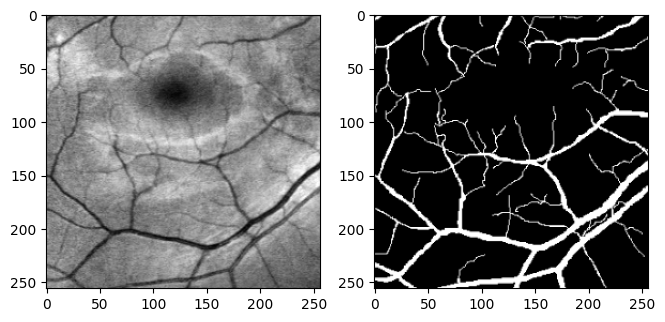

In [ ]:
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 0)

# X_train = np.asarray(X_train).astype('float32').reshape((-1,3))
# y_train = np.asarray(y_train).astype('float32').reshape((-1,3))
# X_test = np.asarray(X_test).astype('float32').reshape((-1,3))
# y_test = np.asarray(y_test).astype('float32').reshape((-1,3))


#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(X_train[image_number],cmap="gray")
plt.subplot(132)
plt.imshow(y_train[image_number], cmap='gray')


In [ ]:
X_train[0].shape

(256, 256, 1)

# **MODEL parameters**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam
from keras.metrics import Recall, Precision


In [ ]:
batch_size = None
lr = 1e-4
num_epochs = 100


In [ ]:
model_path = os.path.join("/content/drive/MyDrive/Drowsiness detection", "att-unet-25-activation-swish.h5")
csv_path = os.path.join("/content/drive/MyDrive/Drowsiness detection", "att-unet-25-activation-swish.csv")

In [ ]:
# IMG_HEIGHT = image_dataset.shape[1]
# IMG_WIDTH  = image_dataset.shape[2]
# IMG_CHANNELS = image_dataset.shape[3]


# model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])
model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 256, 256, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 256, 256, 64)         256       ['conv2d_24[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_20 (Activation)  (None, 256, 256, 64)         0         ['batch_normaliza

# **Training and Testing**

In [ ]:
###############################################################


callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    #ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)
    ]

#If starting with pre-trained weights.
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=150,
                    callbacks=callbacks,
                    validation_data=(X_test, y_test),
                    shuffle=True)

model.save('/content/drive/MyDrive/Drowsiness detection/att-unet-25-activation-swish.hdf5')

Epoch 1/150
50/50 [==============================] - ETA: 0s - loss: 0.4971 - dice_coef: 0.5029 - iou: 0.3364 - recall: 0.8007 - precision: 0.6538
Epoch 1: val_loss improved from inf to 0.89142, saving model to /content/drive/MyDrive/Drowsiness detection/att-unet-25-activation-swish.h5
50/50 [==============================] - 85s 2s/step - loss: 0.4971 - dice_coef: 0.5029 - iou: 0.3364 - recall: 0.8007 - precision: 0.6538 - val_loss: 0.8914 - val_dice_coef: 0.1084 - val_iou: 0.0573 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/150
50/50 [==============================] - ETA: 0s - loss: 0.4492 - dice_coef: 0.5508 - iou: 0.3805 - recall: 0.7915 - precision: 0.7339
Epoch 2: val_loss did not improve from 0.89142
50/50 [==============================] - 84s 2s/step - loss: 0.4492 - dice_coef: 0.5508 - iou: 0.3805 - recall: 0.7915 - precision: 0.7339 - val_loss: 0.9469 - val_dice_coef: 0.0531 - val_iou: 0.0273 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/150
5

In [ ]:
from keras.models import load_model


custom_objects = {'dice_loss': dice_loss, 'dice_coef': dice_coef, 'iou': iou}
new_model = load_model('/content/drive/MyDrive/files/att-unet-patches-overlap-36.h5', custom_objects=custom_objects)

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    #ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)
    ]

#If starting with pre-trained weights.
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')
history = new_model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=140,
                    callbacks=callbacks,
                    validation_data=(X_test, y_test),
                    shuffle=True)

model.save('/content/drive/MyDrive/Drowsiness detection/att-unet-patches-overlap-36-updated.hdf5')

Epoch 1/140
72/72 [==============================] - ETA: 0s - loss: 0.1470 - dice_coef: 0.8530 - iou: 0.7438 - recall: 0.7029 - precision: 0.9836
Epoch 1: val_loss improved from inf to 0.22425, saving model to /content/drive/MyDrive/files/att-unet-patches-overlap-36-updated.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 151s 1s/step - loss: 0.1470 - dice_coef: 0.8530 - iou: 0.7438 - recall: 0.7029 - precision: 0.9836 - val_loss: 0.2243 - val_dice_coef: 0.7757 - val_iou: 0.6340 - val_recall: 0.5492 - val_precision: 0.9813
Epoch 2/140
72/72 [==============================] - ETA: 0s - loss: 0.1468 - dice_coef: 0.8532 - iou: 0.7440 - recall: 0.7032 - precision: 0.9837
Epoch 2: val_loss did not improve from 0.22425
72/72 [==============================] - 101s 1s/step - loss: 0.1468 - dice_coef: 0.8532 - iou: 0.7440 - recall: 0.7032 - precision: 0.9837 - val_loss: 0.2324 - val_dice_coef: 0.7676 - val_iou: 0.6232 - val_recall: 0.5626 - val_precision: 0.9651
Epoch 3/140
72/72 [==============================] - ETA: 0s - loss: 0.1467 - dice_coef: 0.8533 - iou: 0.7443 - recall: 0.7043 - precision: 0.9835
Epoch 3: val_loss did not improve from 0.22425
72/72 [==============================] - 105s 1s/step - loss: 0.1467 - dice_coef: 0.8533 - iou: 0.7443 - recall: 0.7043 

# **Checking**

In [ ]:
!pip install patchify

In [ ]:
# https://youtu.be/LM9yisNYfyw

"""
Applying trained model to large images by dividing them into smaller patches
using patchify.

By loading pre-augmented or patched images and masks.
Use save_patches.py to save patches generated into local drive

This code uses 256x256 images/masks.

pip install patchify
"""
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify


large_image = cv2.imread('/content/drive/MyDrive/DRIVE/image.jpg', 0)
large_image.resize(512,512)
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)

        single_patch = patches[i,j,:,:]
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)

#Predict and threshold for values above 0.5 probability
        single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
        predicted_patches.append(single_patch_prediction)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 256,256) )
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
plt.imsave('/content/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.show()

#plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
#plt.imsave('data/results/output2.jpg', reconstructed_image, cmap='gray')



In [ ]:
from sklearn.utils import shuffle
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [ ]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 13s 620ms/step - loss: 0.2883 - dice_coef: 0.7117 - iou: 0.5524 - recall_2: 0.3588 - precision_2: 0.9953


[0.2883078455924988,
 0.7116921544075012,
 0.5524266958236694,
 0.35878103971481323,
 0.9952916502952576]

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

import numpy as np
import tensorflow as tf
from tensorflow import keras

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "testing_images - Copy", "*.jpg"))) ####### ENTER IMAGE FOLDER NAME
    y = sorted(glob(os.path.join(path, "test_mask", "*.png")))  ####### ENTER MASK FOLDER NAME
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

if __name__ == "__main__":
    """ Save the results in this folder """
    # create_dir("/content/drive/MyDrive/DRIVE (1)/results")

    """ Load the model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("model.h5")  #### ENTER MODEL PATH HERE

    """ Load the dataset """
    dataset_path = "drive_test"  ##### ENTER DATASET PATH HERE
    test_x, test_y = load_data(dataset_path)

    """ Make the prediction and calculate the metrics values """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extracting name """
        name = x.split("\\")[-1].split(".")[0]

        """ Read the image and mask """
        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)
        x = x[:,:,1]

        """ Prediction """
        y_pred = model.predict(np.expand_dims(x, axis=0))[0]
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)
        y_pred = np.squeeze(y_pred, axis=-1)

        """ Saving the images """
        save_image_path = f"results/{name}.png"
        save_results(ori_x, ori_y, y_pred, save_image_path)

        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculate the metrics """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    """ Saving """
    # df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
    # #df.to_csv("/content/drive/MyDrive/DRIVE/files/score.csv")